# SAM Height vs. Width computation

### Correlate the layer with the computed with of the cone to generate a look up table used for alignement

This notebook performs the following tasks:

- Check and correct SAM generated masks as needed
- Take the width and height of the bounding box and correlate with layer (height)
- Perform Filtering and regression for final Look Up table

In [ ]:
# --- Core Libraries ---
import os                       # For interacting with the operating system
import random                   # For generating random numbers
from pathlib import Path         # Object-oriented file system paths
import shutil                    # High-level file operations
import joblib                    # Save and load Python objects

# --- Numerical / Data Handling ---
import numpy as np               # For numerical operations, arrays
import pandas as pd              # For data manipulation and analysis
from scipy import stats          # Statistical functions
from scipy.spatial import distance  # Compute distances between points
from sklearn.linear_model import LinearRegression  # Linear regression

# --- Image Processing Libraries ---
import cv2                       # OpenCV for image/video processing
from skimage.io import imread    # Read images into arrays
from skimage import transform    # Image transformations (resize, rotate, etc.)
from skimage.filters import threshold_otsu  # Otsu thresholding
from skimage.measure import regionprops  # Measure properties of labeled regions
from PIL import Image            # Pillow library for image manipulation
from tifffile import imwrite     # Write TIFF images
import imageio                   # Read/write images in various formats

# --- Plotting ---
import matplotlib.pyplot as plt  # For plotting images and graphs

# --- OpenCV Utilities ---
font = cv2.FONT_HERSHEY_SIMPLEX  # Default font for OpenCV text

# --- Pandas display options ---
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

import imageio
import numpy as np
import os

import random
import pandas as pd

from skimage.io import imread
from skimage import transform
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tifffile import imwrite
from pathlib import Path
font = cv2.FONT_HERSHEY_SIMPLEX
from pathlib import Path
from skimage.filters import threshold_otsu
import shutil
from skimage.measure import regionprops
from scipy.spatial import distance
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import joblib

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.max_colwidth', None)  # Show full column width


In [22]:

# Load both datasets
df_SAM_cones = pd.read_csv("MM_image_cluster_labels_widths_heights_centers.csv")


# Sort both DataFrames by the first column
df_SAM_cones= df_SAM_cones.sort_values(by=df_SAM_cones.columns[0])




In [23]:
df_cone_0 = df_SAM_cones[df_SAM_cones.iloc[:, 1] == 0]
df_cone_0 =df_cone_0 .sort_values(by=df_cone_0 .columns[0])
df_cone_1 = df_SAM_cones[df_SAM_cones.iloc[:, 1] == 1]
df_cone_1= df_cone_1 .sort_values(by=df_cone_1 .columns[0])
df_cone_2 = df_SAM_cones[df_SAM_cones.iloc[:, 1] == 2]
df_cone_2=df_cone_2 .sort_values(by=df_cone_2 .columns[0])

In [ ]:


def clean_duplicates(df):
    """
    This function takes a DataFrame and removes rows that have duplicate values in the first column, 
    keeping the row with the largest value in the last column for each set of duplicates.

    """
    # Find duplicates in the first column
    duplicate_rows = df[df.duplicated(subset=df.columns[0], keep=False)]
    print("Duplicate Rows:")
    print(duplicate_rows)
    print(f"Total number of duplicates: {len(duplicate_rows)}")

    # Sort by the first column and then by the last column (in descending order)
    df_sorted = df.sort_values(by=[df.columns[0], df.columns[-1]], ascending=[True, False])

    # Drop duplicates, keeping the one with the largest value in the last column
    df_cleaned = df_sorted.drop_duplicates(subset=df.columns[0], keep='first')

    # Return the cleaned DataFrame
    print("Cleaned DataFrame:")
    print(df_cleaned)
    print(f"Number of rows after cleaning: {len(df_cleaned)}")
    
    return df_cleaned

# Example usage:
df_cone_0_cleaned = clean_duplicates(df_cone_0)
df_cone_1_cleaned = clean_duplicates(df_cone_1)
df_cone_2_cleaned = clean_duplicates(df_cone_2)


Duplicate Rows:
             image_name  cluster_label  width  height            center
1185  MM_final_0394.tif              0  731.0   796.0  [3377.5, 2275.0]
1183  MM_final_0394.tif              0  633.0   619.0  [3328.5, 2362.5]
1277  MM_final_0425.tif              0  621.0   613.0  [3330.5, 2360.5]
1279  MM_final_0425.tif              0  720.0   803.0  [3379.0, 2272.5]
1307  MM_final_0434.tif              0  714.0   772.0  [3380.0, 2289.0]
1305  MM_final_0434.tif              0  619.0   616.0  [3333.5, 2362.0]
1309  MM_final_0435.tif              0  619.0   618.0  [3333.5, 2362.0]
1311  MM_final_0435.tif              0  715.0   779.0  [3380.5, 2285.5]
1313  MM_final_0436.tif              0  619.0   618.0  [3332.5, 2362.0]
1315  MM_final_0436.tif              0  718.0   790.0  [3381.0, 2280.0]
1334  MM_final_0442.tif              0  720.0   797.0  [3382.0, 2273.5]
1332  MM_final_0442.tif              0  615.0   617.0  [3330.5, 2362.5]
1369  MM_final_0454.tif              0  613.0   

In [25]:
print(len(df_cone_0_cleaned) ,len(df_cone_1_cleaned) ,len(df_cone_2_cleaned))

1983 1983 1983


In [26]:
import os
import pandas as pd
import glob

def update_dataframe_with_missing_files(image_folder, df_cone_2_cleaned):
    # Get all image file names in the folder (only the base names)
    image_files = {os.path.basename(f) for f in glob.glob(os.path.join(image_folder, "*.tif"))}

    # Get file names from the first column of the DataFrame
    df_files = set(df_cone_2_cleaned.iloc[:, 0])  # Assuming filenames are in the first column

    # Find missing files
    missing_files = image_files - df_files
    extra_files = df_files - image_files
    missing_files = sorted(list(missing_files))

    # Display results
    if not missing_files:
        print("✅ All files in the folder are present in the DataFrame.")
    else:
        print("❌ Missing files in DataFrame:", missing_files)

    if not extra_files:
        print("✅ No extra files in the DataFrame.")
    else:
        print("⚠️ Extra files in DataFrame that are not in the folder:", extra_files)

    # If there are missing files, insert them into the DataFrame
    if missing_files:
        # Create a list to hold the new rows
        new_rows = []

        for file in missing_files:
            # Copy the last row to create a new row
            new_row = df_cone_2_cleaned.iloc[-1].copy()  # Start with the last row
            new_row[0] = file  # Set the missing file name in the first column

            # Append this new row to the list of new rows
            new_rows.append(new_row)

        # Convert the list of new rows to a DataFrame
        new_rows_df = pd.DataFrame(new_rows)

        # Concatenate the new rows to the existing DataFrame
        df_cone_2_cleaned = pd.concat([df_cone_2_cleaned, new_rows_df], ignore_index=True)

    # Return the updated DataFrame
    return df_cone_2_cleaned


# Example of how to use this function:
# Define the folder path and load the DataFrame
image_folder = "/pn_local/2_1/final/MM_full_stack/"
df_cone_0_finale= update_dataframe_with_missing_files(image_folder, df_cone_0_cleaned)
df_cone_1_finale= update_dataframe_with_missing_files(image_folder, df_cone_1_cleaned)
df_cone_2_finale= update_dataframe_with_missing_files(image_folder, df_cone_2_cleaned)
# df_cone_2_cleaned = pd.read_csv('your_dataframe.csv')  # Uncomment to load the DataFrame

# Call the function
# df_cone_2_cleaned_updated = update_dataframe_with_missing_files(image_folder, df_cone_2_cleaned)

# After modifying the DataFrame, you might want to save the result back to a CSV
# df_cone_2_cleaned_updated.to_csv('updated_dataframe.csv', index=False)  # Uncomment to save


✅ All files in the folder are present in the DataFrame.
✅ No extra files in the DataFrame.
✅ All files in the folder are present in the DataFrame.
✅ No extra files in the DataFrame.
✅ All files in the folder are present in the DataFrame.
✅ No extra files in the DataFrame.


In [27]:
print(len(df_cone_0_finale) ,len(df_cone_1_finale) ,len(df_cone_2_finale))

1983 1983 1983


In [28]:
print(len(df_cone_0_cleaned) ,len(df_cone_1_cleaned) ,len(df_cone_2_cleaned))

1983 1983 1983


In [29]:
df_cone_0_cleaned.head()

,image_name,cluster_label,width,height,center
0,MM_final_0000.tif,0,707.0,712.0,"[3318.5, 2376.0]"
3,MM_final_0001.tif,0,705.0,711.0,"[3318.5, 2376.5]"
7,MM_final_0002.tif,0,708.0,712.0,"[3318.0, 2377.0]"
11,MM_final_0003.tif,0,707.0,711.0,"[3318.5, 2376.5]"
13,MM_final_0004.tif,0,707.0,712.0,"[3319.5, 2377.0]"


1983
1983
1983


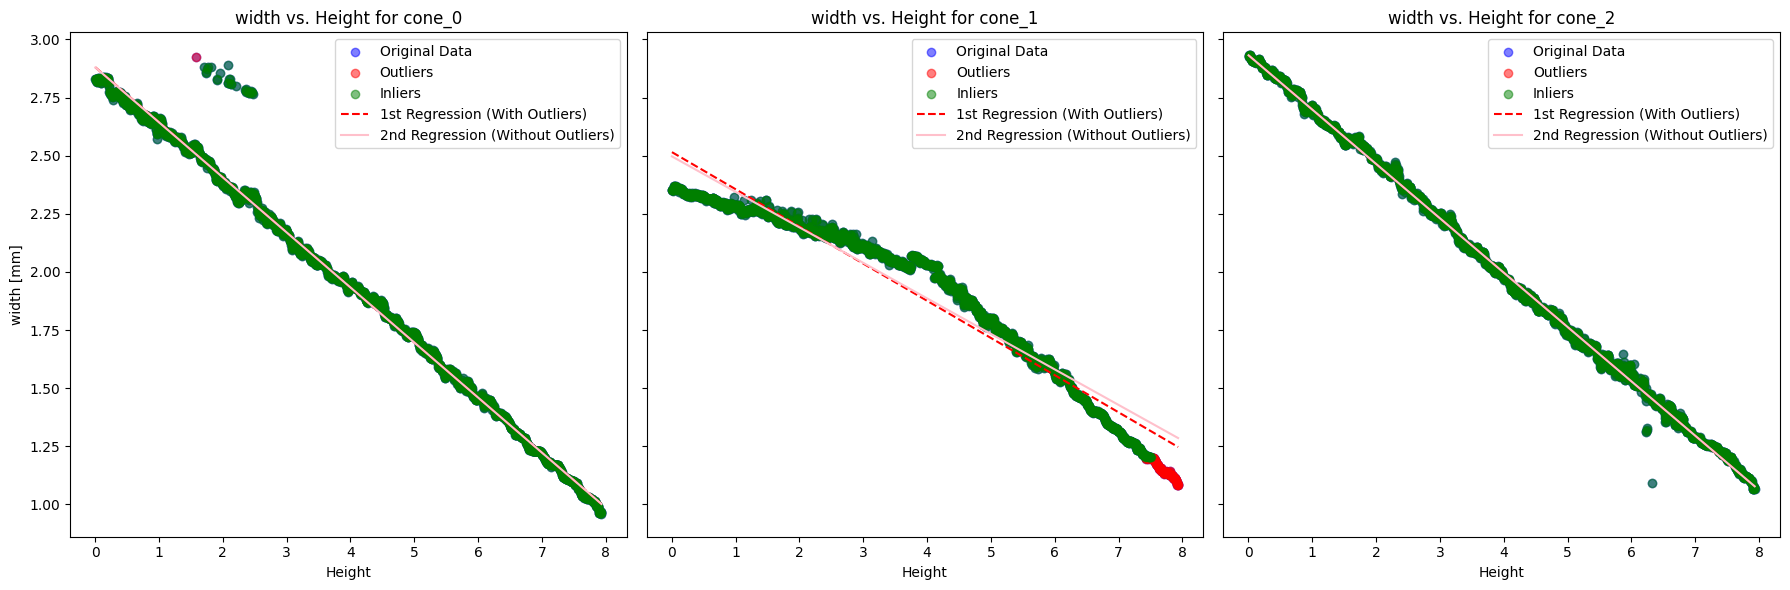

1983
1983
1983


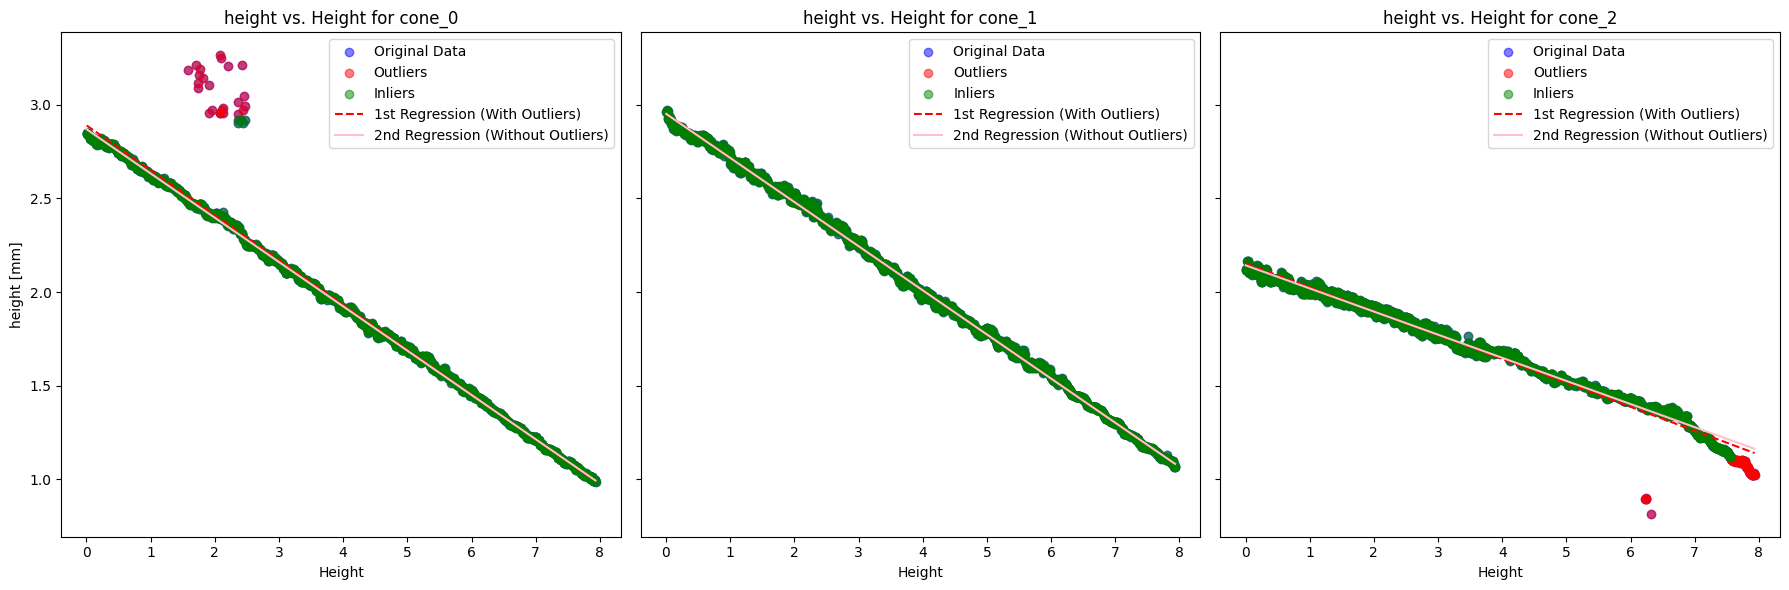

In [ ]:
"""
Performs regression analysis on cone measurement data (width and height) for multiple cones.

For each cone dataset:
1. Generates x-values (height) and scales y-values (width or height).
2. Removes outliers based on Z-scores.
3. Fits two linear regression models: 
   - Model 1: using all data (including outliers)
   - Model 2: using inliers only
4. Visualizes results with scatter plots showing original data, inliers, outliers, 
   and regression lines (with and without outliers).
5. Saves predicted regression values to CSV files for each cone.
6. Saves trained regression models to disk as .pkl files.
7. Combines all regression data into a single CSV file for further analysis.
"""


def perform_regression(x, y):
    """Fit a linear regression model to the data and return the model."""
    model = LinearRegression()
    x_reshaped = x.reshape(-1, 1)  # Reshape x for the model
    model.fit(x_reshaped, y)
    return model

def remove_outliers(x, y):
    """Remove outliers using Z-scores."""
    z_scores = np.abs(stats.zscore(y))  # Calculate z-scores for y-values
    inlier_mask = z_scores < 1.8  # Keep data with z-score less than 1.8 (remove outliers)
    
    x_inliers, y_inliers = x[inlier_mask], y[inlier_mask]  # Inliers (valid points)
    x_outliers, y_outliers = x[~inlier_mask], y[~inlier_mask]  # Outliers (removed points)
    
    return x_inliers, y_inliers, x_outliers, y_outliers

def analyze_cone_data(cones, attribute):
    """Analyze cone data for the given attribute (width or HEIGHT) and perform regression analysis."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    regression_data = {}
    
    for i, (cone_name, df_cone) in enumerate(cones.items()):
        x_values = np.arange(0.004,0.004 * (len(df_cone) + 1), 0.004)  # Ensure correct number of x-values
        y_values = df_cone[attribute] * 0.004  # Scale y-values by 0.003
       # print(len(x_values))
        
        # Remove outliers
        x_inliers, y_inliers, x_outliers, y_outliers = remove_outliers(x_values, y_values)
        
        # Perform first regression (with outliers)
        model1 = perform_regression(x_values, y_values)
        y_pred1 = model1.predict(x_values.reshape(-1, 1))
        
        # Perform second regression (after outlier removal)
        model2 = perform_regression(x_inliers, y_inliers)
        
        # Predict for the full x_values range using the second model (fitted on inliers)
        y_pred2 = model2.predict(x_values.reshape(-1, 1))  # Generate predictions for the entire x_values range
        print(len(y_pred2))
        # Scatter original data points
        axes[i].scatter(x_values, y_values, alpha=0.5, color='blue', label="Original Data")
        
        # Scatter outliers in red
        axes[i].scatter(x_outliers, y_outliers, alpha=0.5, color='red', label="Outliers")
        
        # Scatter inliers in green
        axes[i].scatter(x_inliers, y_inliers, alpha=0.5, color='green', label="Inliers")
        
        # Plot first regression line (with outliers)
        axes[i].plot(x_values, y_pred1, color='red', linestyle="dashed", label="1st Regression (With Outliers)")
        
        # Plot second regression line (without outliers, but predicted for the full x_values range)
        axes[i].plot(x_values, y_pred2, color='pink', label="2nd Regression (Without Outliers)")
        
        # Store the final regression values for DataFrame with full x_values (including outliers)
        regression_data[cone_name] = pd.DataFrame({
            "Height": x_values,  # Full x_values range (no truncation)
            f"{attribute}_Predicted": y_pred2  # Full regression line predictions (without outliers)
        })
        
        # Add titles and labels
        axes[i].set_xlabel("Height")
        axes[i].set_title(f"{attribute} vs. Height for {cone_name}")
        axes[i].legend()
    
    # Set common y-label
    axes[0].set_ylabel(f"{attribute} [mm]")
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Save the regression data as a DataFrame for each cone, including the full x_values range
    for cone_name, df in regression_data.items():
        df.to_csv(f"MM_regression_data_1{cone_name}_{attribute}.csv",mode = "w", index=False)
    
    # Save the models for future use
    for cone_name in cones.keys():
        joblib.dump(model1, f'MM_model_{cone_name}_{attribute}_first_regression.pkl')
        joblib.dump(model2, f'MM_model_{cone_name}_{attribute}_second_regression.pkl')
    
    # Combine all regression data into one DataFrame (optional)
    final_df = pd.concat(regression_data, names=["Cone", "Index"])
    final_df.to_csv(f"MM_final_regression_data_{attribute}.csv",mode = "w")

# Define cone datasets in a dictionary
cones = {"cone_0": df_cone_0_finale, "cone_1": df_cone_1_finale, "cone_2": df_cone_2_finale}

# Run analysis for both "width" and "HEIGHT"
analyze_cone_data(cones, "width")
analyze_cone_data(cones, "height")
